<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-4/blob/main/super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelado de SuperResolution y GAN

## Instalación de paquetes necesarios para la realización del modelo

Primero necesitamos instalar los paquetes wwf, fastcore y fastai. Inicialmente instalamos los que son requeridos para la realización del modelo. Tras encontrarnos errores durante el procceso de creación, tuvimos que modificarlos para solucionarlos.

In [ ]:
!pip install wwf==0.0.7

In [ ]:
#!pip install fastcore==1.3.13

     |████████████████████████████████| 61kB 9.0MB/s 
  Found existing installation: fastcore 1.3.20
    Uninstalling fastcore-1.3.20:
      Successfully uninstalled fastcore-1.3.20


In [ ]:
#!pip install fastai==2.1.10

     |████████████████████████████████| 194kB 27.9MB/s 
  Found existing installation: fastai 2.3.1
    Uninstalling fastai-2.3.1:
      Successfully uninstalled fastai-2.3.1


In [ ]:
!pip install git+https://github.com/fastai/fastai

  Cloning https://github.com/fastai/fastai to /tmp/pip-req-build-lxly4dsv
  Running command git clone -q https://github.com/fastai/fastai /tmp/pip-req-build-lxly4dsv
  Created wheel for fastai: filename=fastai-2.3.1-cp37-none-any.whl size=193488 sha256=d01eee55a63084e0d5177dcf355ea9deff04b4d5f9a14a1cd2c0a846fe855dd0
  Stored in directory: /tmp/pip-ephem-wheel-cache-0718i6f9/wheels/83/30/a0/6fa8a74c9f5a5ab45cdc84e9f9ed56d8a72750e11ebf50a364
Successfully built fastai


In [ ]:
!pip install git+https://github.com/fastai/fastcore

  Cloning https://github.com/fastai/fastcore to /tmp/pip-req-build-bazjn9bc
  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-bazjn9bc
  Created wheel for fastcore: filename=fastcore-1.3.20-cp37-none-any.whl size=52529 sha256=225a81d2c23aab584b79c112d68b5fbfb844e5f469a749d177651b26d3ad47b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-vepcpz4t/wheels/8a/2a/23/bc50c8f5e28776b44ac837a01fcfa675724565d4813d8e51c7
Successfully built fastcore
  Found existing installation: fastcore 1.3.19
    Uninstalling fastcore-1.3.19:
      Successfully uninstalled fastcore-1.3.19


##Importar paquetes

Durante la realización del proyecto vamos a necesitar importar bastantes paquetes para la realización de este.

In [ ]:
from fastai.vision.all import *
from fastai.vision.gan import *
from PIL import ImageDraw, ImageFont

## Pixelación de las imagenes

A partir de un dataset ya generado, vamos a diferenciar dos carpetas en las que se encuentren las imagenes originales sin modificar y las imagenes pixeladas para entrenar.

In [ ]:
def resize_to(img, targ_sz, use_min=False):
    w,h = img.size
    min_sz = (min if use_min else max)(w,h)
    ratio = targ_sz/min_sz
    return int(w*ratio),int(h*ratio)

In [ ]:
class Crappifier():
  "Quickly draw tesxt and numbers on an image"
  def __init__(self, path_lr, path_hr):
      self.path_lr = path_lr
      self.path_hr = path_hr              
      
  def __call__(self, fn):       
      dest = self.path_lr/fn.relative_to(self.path_hr)    
      dest.parent.mkdir(parents=True, exist_ok=True)
      img = Image.open(fn)
      targ_sz = resize_to(img, 96, use_min=True)
      img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
      w,h = img.size
      q = random.randint(10,70)
      ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
      img.save(dest, quality=q)

Para tener imagenes con las que trabajar, vamos a usar un dataset de mascotas.

In [ ]:
path = untar_data(URLs.PETS)

Crearemos dos carpetas, una para las imagenes de baja resolución y una para las de alta resolución

In [ ]:
path_hr = path/'images'
path_lr = path/'crappy'

A partir de esta estructura ya podemos crear nuestro dataset

In [ ]:
items = get_image_files(path_hr)

In [ ]:
items

(#7390) [Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_94.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_48.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_206.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_83.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_78.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_21.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_56.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_52.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_76.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_49.jpg')...]

In [ ]:
parallel(Crappifier(path_lr, path_hr), items);

A continuación vamos a poder ver el resultado de una de las imagenes modficadas previamente.

In [ ]:
bad_im = get_image_files(path_lr)

In [ ]:
im1 = PILImage.create(items[0])
im2 = PILImage.create(bad_im[0])

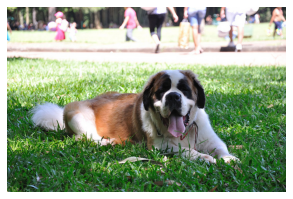

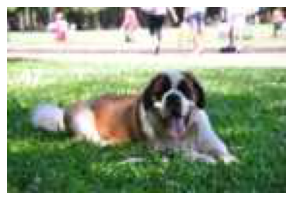

In [ ]:
im1.show(); im2.show(figsize=(5,5))

## Creación del DataBlock

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])

In [ ]:
def get_dls(bs:int, size:int):
  "Generates two `GAN` DataLoaders"
  dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path_lr, bs=bs, path=path)
  dls.c = 3 # For 3 channel image
  return dls

## Crear un generador pre entrenado

Con este modelo queremos conseguir mejorar las imagenes que se ven pixeladasy que tengan algun defecto evidente. En nuestro caso le hemos añadido previamente a las imagenes un numero o texto que el modelo tratará de eliminar de la imagen.

In [ ]:
dls_gen = get_dls(32, 128)

A la izquierda se puede ver la imagen que ha sido modificada y a la derecha la imagenes originales

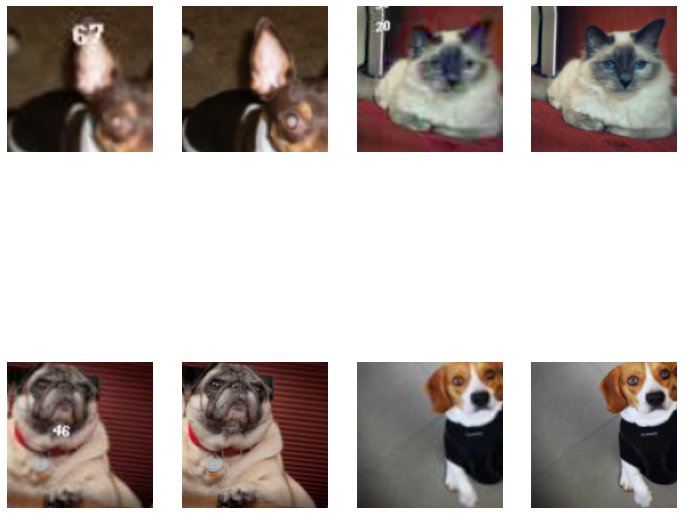

In [ ]:
dls_gen.show_batch(max_n=4, figsize=(12,12))

In [ ]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

Para crear el modelo vamos a utilizarl resnet34

In [ ]:
bbone = resnet34

In [ ]:
def create_gen_learner():
  return unet_learner(dls_gen, bbone, loss_func=loss_gen)

In [ ]:
learn_gen = create_gen_learner()

Comenzamos a entrenar el modelo, lo vamos a hacer en un par de tandadas cortas

In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,1.342510,1.015571,01:19
1,0.735932,0.752718,01:15


In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.714827,0.745934,01:19
1,0.679294,0.678816,01:19
2,0.649785,0.666529,01:20


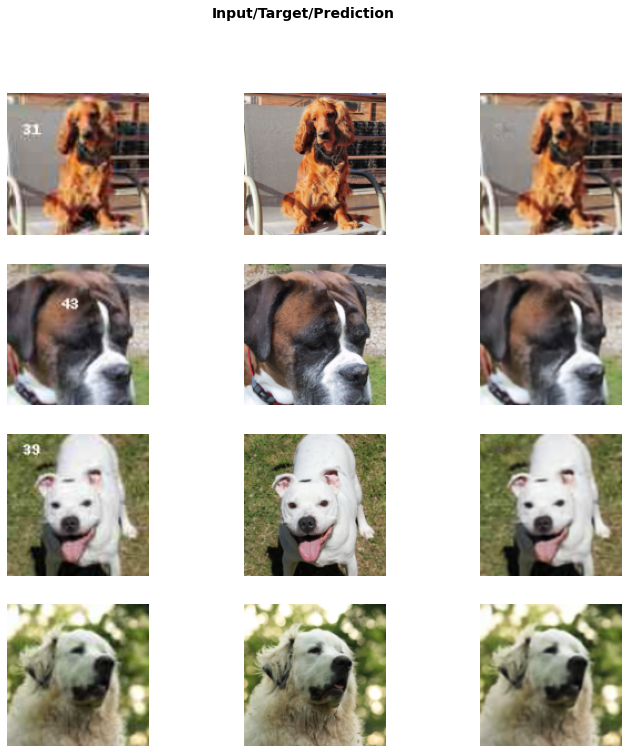

In [ ]:
learn_gen.show_results(max_n=4, figsize=(12,12))

Tras realizar el modelo procedemos a guardarlo

In [ ]:
learn_gen.save('gen-pre2')

Path('/root/.fastai/data/oxford-iiit-pet/models/gen-pre2.pth')

## Guardar las imágenes generadas

Una vez generadas las imagenes, necesitamos guardarlas para luego poder usarlas en nuestro modelo.

In [ ]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
path_gen.mkdir(exist_ok=True)

In [ ]:
def save_preds(dl, learn):
  "Save away predictions"
  names = dl.dataset.items
  
  preds,_ = learn.get_preds(dl=dl)
  for i,pred in enumerate(preds):
      dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
      arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
      Image.fromarray(arr).save(path_gen/names[i].name)

In [ ]:
dl = dls_gen.train.new(shuffle=False, drop_last=False, 
                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [ ]:
preds, _ = learn_gen.get_preds(dl=dl)

In [ ]:
preds[0].shape

torch.Size([3, 128, 128])

In [ ]:
preds[0][None].shape

torch.Size([1, 3, 128, 128])

In [ ]:
dec = dl.after_batch.decode((TensorImage(preds[0][None]),))[0][0]

In [ ]:
arr = dec.numpy().transpose(1,2,0)

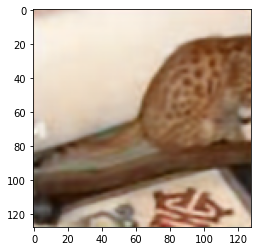

In [ ]:
plt.imshow(arr.astype(np.uint8))

In [ ]:
save_preds(dl, learn_gen)

## Entrenando el modelo critico

Ahora ya podemos proceder a crear el modelo critico

In [ ]:
path_gen

Path('/root/.fastai/data/oxford-iiit-pet/image_gen')

In [ ]:
name_gen

'image_gen'

In [ ]:
path_g = get_image_files(path/name_gen)
path_i = get_image_files(path/'images')
fnames = path_g + path_i

In [ ]:
fnames[0]

Path('/root/.fastai/data/oxford-iiit-pet/image_gen/saint_bernard_94.jpg')

In [ ]:
def get_crit_dls(fnames, bs:int, size:int):
  "Generate two `Critic` DataLoaders"
  splits = RandomSplitter(0.1)(fnames)
  dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]],
                 splits=splits)
  tfms = [ToTensor(), Resize(size)]
  gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
  return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms)

In [ ]:
dls_crit = get_crit_dls(fnames, bs=32, size=128)

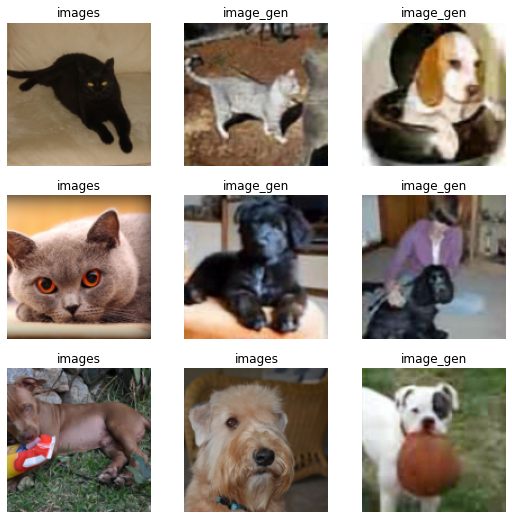

In [ ]:
dls_crit.show_batch()

In [ ]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [ ]:
def create_crit_learner(dls, metrics):
  return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [ ]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

In [ ]:
pip install -Uqq nbdev

Una vez realizado rodos los pasos anteriores, ya podemos entrenar el modelo critico, pero aqui nos encontramos con algunos problemas que tuvimos que solucionar con las siguientes celdas que instalará veriones más nuevas de fastai

In [ ]:
def forward(self, x):
  x = self.m(x)
  x = torch.flatten(x, 1)
  x = torch.Tensor(x.cpu().float()).float().cuda()
  return x

In [ ]:
!pip install git+https://github.com/fastai/fastai

  Cloning https://github.com/fastai/fastai to /tmp/pip-req-build-36x1mutr
  Running command git clone -q https://github.com/fastai/fastai /tmp/pip-req-build-36x1mutr
  Created wheel for fastai: filename=fastai-2.3.1-cp37-none-any.whl size=193488 sha256=a79e1ef461d5415c14b5e7610fc64708a3d59b7eb970d4250a82540906ab5348
  Stored in directory: /tmp/pip-ephem-wheel-cache-5zr0s0wn/wheels/83/30/a0/6fa8a74c9f5a5ab45cdc84e9f9ed56d8a72750e11ebf50a364
Successfully built fastai
  Found existing installation: fastai 2.1.10
    Uninstalling fastai-2.1.10:
      Successfully uninstalled fastai-2.1.10


Ya si que estamos listos para poder realizar el entreno del modelo

In [ ]:
#learn_crit.fit_one_cycle(6, 1e-3, wd=wd)
learn_crit.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.661523,0.683451,0.535448,03:34
1,0.262433,0.132111,0.957655,03:30
2,0.070458,0.023732,0.995255,03:30
3,0.033354,0.015625,0.997324,03:29
4,0.023675,0.006368,0.998510,03:29
5,0.012046,0.005050,0.999090,03:29


In [ ]:
learn_crit.save('critic-pre2')

Path('models/critic-pre2.pth')

## Realización de un GAN

Ahora vamos a combinar los dos modelos para juntarlo en un GAN

In [ ]:
ls_crit = get_crit_dls(fnames, bs=32, size=128)

In [ ]:
learn_crit = create_crit_learner(dls_crit, metrics=None).load('critic-pre2')

In [ ]:
learn_gen = create_gen_learner().load('gen-pre2')

La última cosa que haremos es definir el GAN. Esto lo vamos a hacer desde learners, y especificar cual es el generador y cual es el critico. El intercambiador es una llamada que decide cuando cambiar de uno a otro.

En esta parte, vamos a hacer tantas iteraciones del discriminador como sean necesarias hasta que la perdida es menor que 0,65 y entonces hacer una iteración del generador.

La función de perdida del critico es una funcion de perdida del learn_crit's. Tomaremos la media del batch de las predicciones reales(targ 1) o no reales (targ 0).

La función de perdida del generador es una suma de pesos de learn_crit.loss_func en el batch de imagenes generadas con un target 1, y and_gen.loss_func es aplicada a la salida y al target.

In [ ]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training: 
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

In [ ]:
switcher = AdaptiveGANSwitcher(critic_thresh=.65)

In [ ]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.))

In [ ]:
lr = 1e-7

Ahora ya lo podemos poner a entrenar

In [ ]:
learn.fit(3, lr, wd=wd)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,3.025205,1133.336182,1133.336182,3.357763,03:27
1,3.774460,1133.336182,1133.336182,1.891418,03:34
2,3.699763,1133.336182,1133.336182,3.911621,03:35


/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


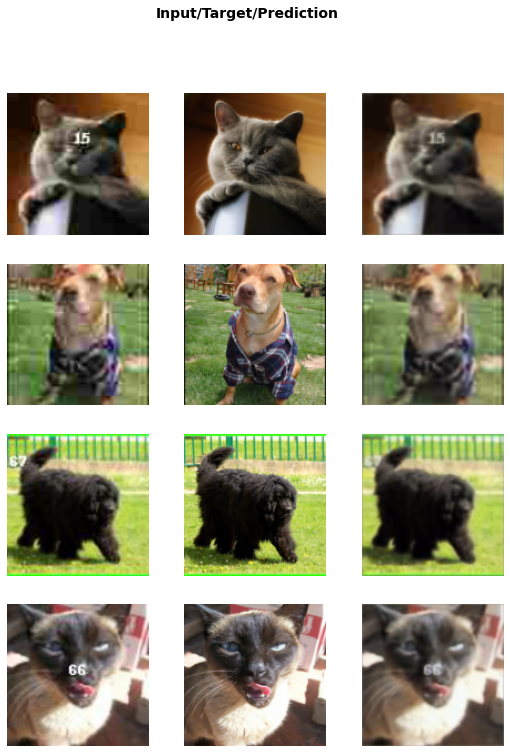

In [ ]:
learn.show_results(max_n=4)

In [ ]:
learn_crit.save('super_resolution')

Path('models/super_resolution.pth')